# Parallel XEB

In [1]:
import cirq
import numpy as np

## Set up Random Circuits

We create a set of 20 random, two-qubit `circuits`

In [2]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

circuits = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.ISWAP**0.5,
)
print(len(circuits))

20


In [3]:
# We will truncate to these lengths
cycle_depths = np.arange(3, 75, 11)
cycle_depths

array([ 3, 14, 25, 36, 47, 58, 69])

## Make a device to run in parallel on

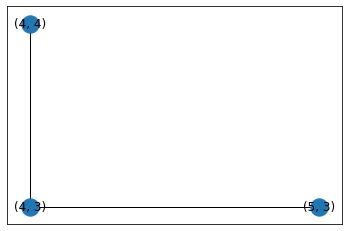

In [4]:
qubits = cirq.GridQubit.rect(3, 2, 4, 3)
qubits = qubits[:-1]  # make it irregular
qubits = qubits[:-2]  # make it tiny
sampler = cirq.DensityMatrixSimulator(noise=cirq.depolarize(5e-3))

import cirq.contrib.routing as ccr
import networkx as nx
graph = ccr.gridqubits_to_graph_device(qubits)
pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

In [5]:
# import cirq.contrib.routing as ccr
# import cirq.google as cg
# import os
# os.environ['GOOGLE_CLOUD_PROJECT'] = 'google.com:quantum-experiments'
# device_name = 'mcgee'
# sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')

# device = cg.get_engine_device(device_name)
# qubits = sorted(device.qubits)
# if device_name == 'mcgee':
#     qubits = qubits[:-2]
#     qubits.remove(cirq.GridQubit(2,3))
# if device_name == 'rainbow':
#     qubits = cirq.GridQubit.rect(3,2,4,3)

# graph = ccr.gridqubits_to_graph_device(qubits)
# pos = {q: (q.row, q.col) for q in qubits}
# nx.draw_networkx(graph, pos=pos)

## Set up our combinations
We take the library of two-qubit circuits and mix-and-match to run parallel efficiently.

We pass to the sampling function and it will "zip" the circuits according to these combinations which are given by a GridInteractionLayer (one of four for the degree-four GridQubit implied graph), and a row of circuit indices.

In [6]:
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuits),
    n_combinations=20,
    device_graph=graph,
)
combs_by_layer

[CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=1, vertical=True, stagger=True), combinations=array([[ 1],
        [ 9],
        [ 0],
        [11],
        [ 0],
        [18],
        [ 2],
        [16],
        [ 5],
        [ 1],
        [18],
        [ 3],
        [ 1],
        [ 4],
        [17],
        [13],
        [19],
        [ 8],
        [15],
        [10]]), pairs=[(cirq.GridQubit(4, 3), cirq.GridQubit(5, 3))]),
 CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=1, vertical=False, stagger=True), combinations=array([[ 1],
        [18],
        [13],
        [11],
        [12],
        [11],
        [ 3],
        [ 0],
        [16],
        [19],
        [ 7],
        [ 5],
        [12],
        [19],
        [ 3],
        [ 9],
        [ 7],
        [ 1],
        [ 5],
        [16]]), pairs=[(cirq.GridQubit(4, 3), cirq.GridQubit(4, 4))])]

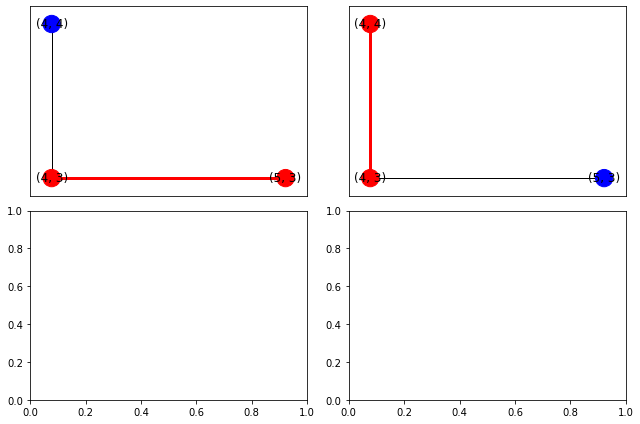

In [7]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(9,6))
for comb_layer, ax in zip(combs_by_layer, axes.reshape(-1)):
    active_qubits = np.array(comb_layer.pairs).reshape(-1)
    colors = ['red' if q in active_qubits else 'blue' for q in graph.nodes]
    nx.draw_networkx(graph, pos=pos, node_color=colors, ax=ax)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=comb_layer.pairs, width=3, edge_color='red', ax=ax)
    
plt.tight_layout()

In [8]:
from cirq.experiments.fidelity_estimation import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuits,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer
)
sampled_df

288it [01:14,  3.85it/s]                         


,,sampled_probs,layer_i,pair_i,combination_i,pair_name,q0,q1
circuit_i,cycle_depth,,,,,,,
1,3,"[0.0344, 0.5223, 0.3016, 0.1417]",0,0,0,"(4, 3)-(5, 3)","(4, 3)","(5, 3)"
9,3,"[0.071, 0.2801, 0.5564, 0.0925]",0,0,1,"(4, 3)-(5, 3)","(4, 3)","(5, 3)"
0,3,"[0.0233, 0.3545, 0.0624, 0.5598]",0,0,2,"(4, 3)-(5, 3)","(4, 3)","(5, 3)"
11,3,"[0.4734, 0.0284, 0.3531, 0.1451]",0,0,3,"(4, 3)-(5, 3)","(4, 3)","(5, 3)"
0,3,"[0.0234, 0.3674, 0.0598, 0.5494]",0,0,4,"(4, 3)-(5, 3)","(4, 3)","(5, 3)"
...,...,...,...,...,...,...,...,...
3,69,"[0.3149, 0.2079, 0.2733, 0.2039]",1,0,14,"(4, 3)-(4, 4)","(4, 3)","(4, 4)"
9,69,"[0.2453, 0.2306, 0.3141, 0.21]",1,0,15,"(4, 3)-(4, 4)","(4, 3)","(4, 4)"
7,69,"[0.2625, 0.2722, 0.2082, 0.2571]",1,0,16,"(4, 3)-(4, 4)","(4, 3)","(4, 4)"


In [9]:
#sampled_df.to_pickle('02-03-mcgee.pickl')
#cirq.to_json(circuits, '02-03-mcgee.json')

In [10]:
from cirq.experiments.fidelity_estimation import benchmark_2q_xeb_fidelities
# TODO: only simulate the circuits that are here
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuits,
    cycle_depths=cycle_depths,
)
fids

,layer_i,pair_i,cycle_depth,fidelity,q0,q1,pair_name
0,0,0,3,0.927034,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
1,0,0,14,0.717671,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
2,0,0,25,0.573164,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
3,0,0,36,0.453712,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
4,0,0,47,0.352391,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
5,0,0,58,0.279952,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
6,0,0,69,0.229378,"(4, 3)","(5, 3)","(4, 3)-(5, 3)"
7,1,0,3,0.925950,"(4, 3)","(4, 4)","(4, 3)-(4, 4)"
8,1,0,14,0.723725,"(4, 3)","(4, 4)","(4, 3)-(4, 4)"
9,1,0,25,0.577695,"(4, 3)","(4, 4)","(4, 3)-(4, 4)"


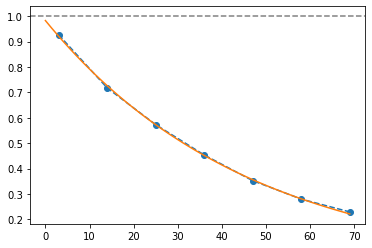

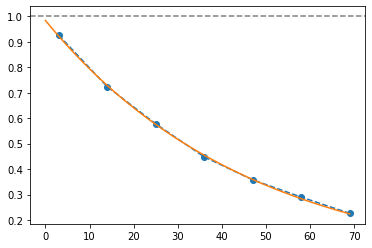

In [13]:
from cirq.experiments.fidelity_estimation import fit_decays, exp
for record in fit_decays(fids):
    plt.axhline(1, color='grey', ls='--')
    plt.plot(record['cycle_depths'], record['fidelities'], 'o--')
    xx = np.linspace(0, np.max(record['cycle_depths']))
    plt.plot(xx, exp(xx, A=record['A'], fid=record['fid']))
    plt.show()

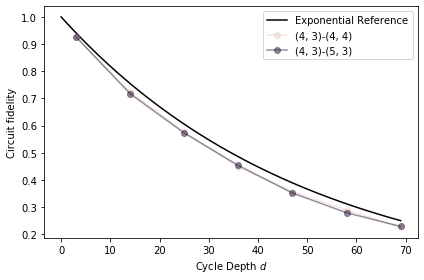

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Give each pair its own color
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = {f'{q0}-{q1}': color for (q0, q1), color in zip(graph.edges, colors)}

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference', color='black')

# Plot each pair
def _p(fids):
    plt.plot(fids['cycle_depth'], fids['fidelity'], 
             'o-', label=fids.name, color=colors[fids.name],
             alpha=0.5)
fids.groupby('pair_name').apply(_p)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')
plt.tight_layout()

## Optimize `PhasedFSimGate` parameters

We know what circuits we requested, and in this simulated example, we know what coherent error has happened. But in a real experiment, there is likely unknown coherent error that you would like to characterize. Therefore, we make the five angles in `PhasedFSimGate` free parameters and use a classical optimizer to find which set of parameters best describes the data we collected from the noisy simulator (or device, if this was a real experiment).

fids_opt = simulate_2q_xeb_fids(sampled_df, pcircuits, cycle_depths, param_resolver={'theta': -np.pi/4, 'phi': 0.1})

In [15]:
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()

```python
from cirq.experiments.fidelity_estimation import \
    parameterize_phased_fsim_circuit, characterize_phased_fsim_parameters_with_xeb, SqrtISwapXEBOptions

options = SqrtISwapXEBOptions()
pcircuits = [parameterize_phased_fsim_circuit(circuit, options) for circuit in circuits]
res = characterize_phased_fsim_parameters_with_xeb(
                    sampled_df, pcircuits, cycle_depths, options, pool=pool, fatol=5e-3, xatol=5e-3)
```

In [16]:
from cirq.experiments.fidelity_estimation import \
    parameterize_phased_fsim_circuit, characterize_phased_fsim_parameters_with_xeb_by_pair, SqrtISwapXEBOptions

options = SqrtISwapXEBOptions()
pcircuits = [parameterize_phased_fsim_circuit(circuit, options) for circuit in circuits]
oresults, angles, fids_opt = characterize_phased_fsim_parameters_with_xeb_by_pair(
                             sampled_df, pcircuits, cycle_depths, options, pool=pool, fatol=5e-3, xatol=5e-3)

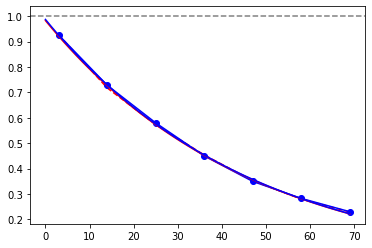

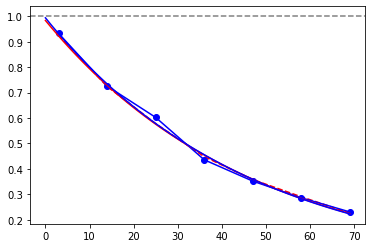

In [18]:
for r1, r2 in zip(fit_decays(fids), fit_decays(fids_opt)):
    assert r1['pair_name'] == r2['pair_name']
    plt.axhline(1, color='grey', ls='--')
    plt.plot(r1['cycle_depths'], r1['fidelities'], '--', color='red')
    plt.plot(r2['cycle_depths'], r2['fidelities'], 'o-', color='blue')

    xx = np.linspace(0, np.max(r1['cycle_depths']))
    plt.plot(xx, exp(xx, A=r1['A'], fid=r1['fid']), color='red')
    plt.plot(xx, exp(xx, A=r2['A'], fid=r2['fid']), color='blue')
    
    plt.show()

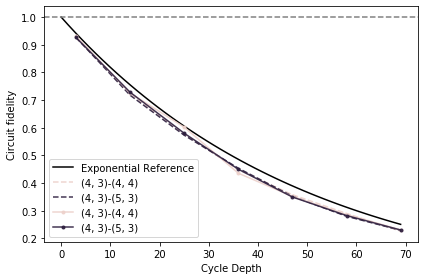

In [19]:
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference', color='black')
plt.axhline(1, color='grey', ls='--')

#plt.plot(fids['cycle_depth'], fids['fidelity'], 'o-', label='Raw')
#plt.plot(fids_opt['cycle_depth'], fids_opt['fidelity'], 'o-', label='Refit')

# Plot each pair
def _p(fids, marker='.', ls='-'):
    plt.plot(fids['cycle_depth'], fids['fidelity'], 
             marker=marker, ls=ls, label=fids.name, color=colors[fids.name],
             alpha=0.9)

fids.groupby('pair_name').apply(_p, ls='--', marker='')
fids_opt.groupby('pair_name').apply(_p)
#plt.yscale('log')

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth')
plt.legend(loc='best')
plt.tight_layout()